Model selection
===============

We know that (in the “classic” view), the test error of a model tends to decrease and then increase as we increase model complexity. For low complexity, the bias dominates; for high complexity, the variance dominates.

The training error, however, only decreases with increasing model complexity. If we use training error to select a model, we’ll select a model that overfits. And during training, when we select a model, only the training error is available to us.

![Image from “Elements of Statistical Learning”](https://i.stack.imgur.com/alkeM.png)

*Image source: Elements of Statistical Learning*

The solution is cross validation. Until now, we have been dividing our data into two parts:

-   Training data: used to train the model
-   Test data: used to evaluate the performance of our model on new, unseen data

Now, we will make one more split:

-   Training data: used to train the model
-   Validation data: used to select the model complexity (usually by tuning some *hyperparameters*)
-   Test data: used to evaluate the performance of our model on new, unseen data

Furthermore, we will refine this idea in order to reduce the dependence on the particular samples we choose for the training, and to increase the number of samples available for training. In K-fold cross validation, we split the data into $K$ parts, each part being approximately equal in size. For each split, we fit the data on $K-1$ parts and test the data on the remaining part. Then, we average the score over the $K$ parts.

For example, for $K=5$, it might look like this:

![](https://scikit-learn.org/stable/_images/grid_search_cross_validation.png)

In [1]:
from sklearn import datasets
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

from ipywidgets import interact, fixed, widgets
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Model selection using best K-Fold CV score

First, we will try to use K-fold CV to select a polynomial model to fit the data in our first example.

We will use the `scikit-learn` module for K-fold CV.

In [2]:
def generate_polynomial_regression_data(n=100, xrange=[-1,1], coefs=[1,0.5,0,2], sigma=0.5):
  x = np.random.uniform(xrange[0], xrange[1], n)
  y = np.polynomial.polynomial.polyval(x,coefs) + sigma * np.random.randn(n)

  return x.reshape(-1,1), y

interactive(children=(IntSlider(value=1, description='d', max=25, min=1), Checkbox(value=True, description='sh…

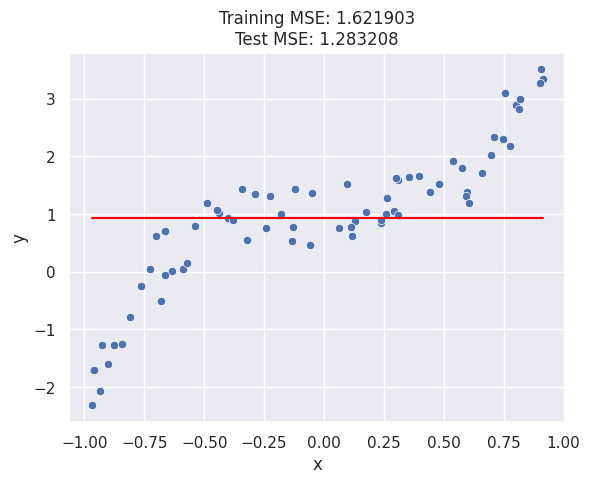

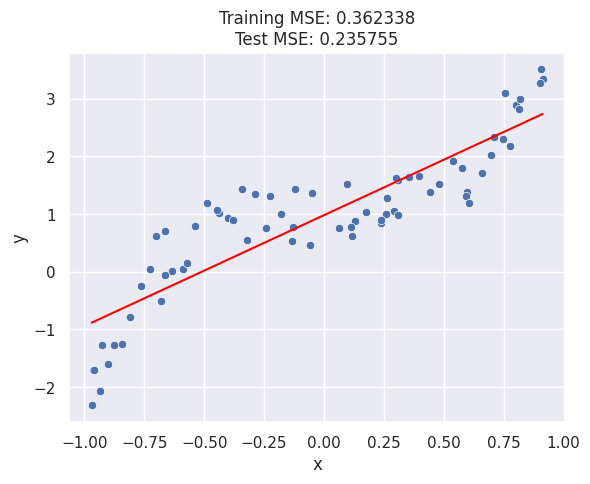

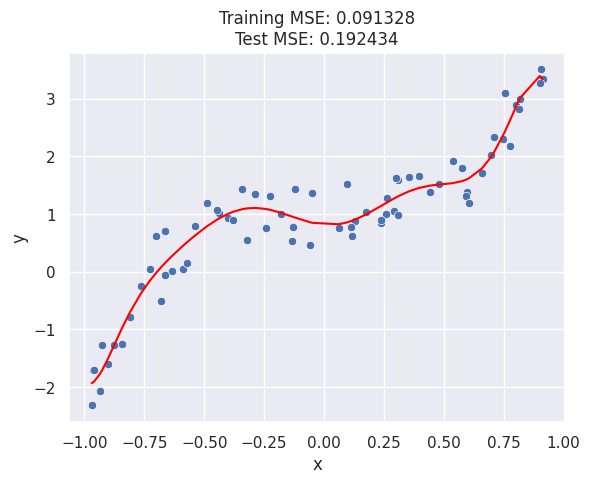

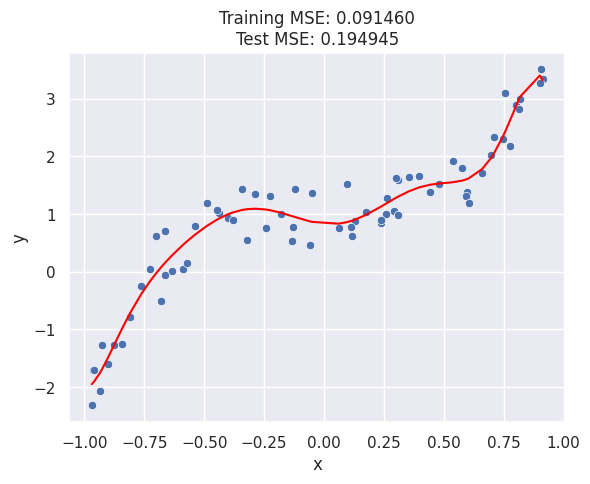

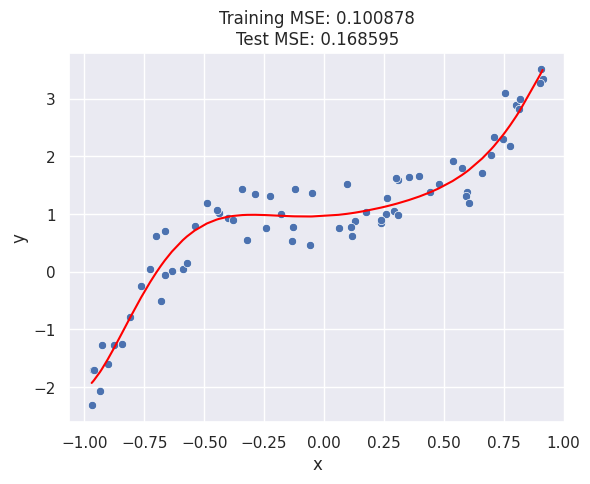

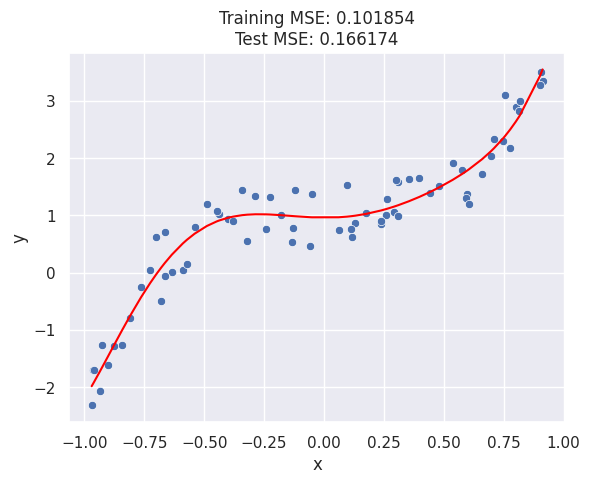

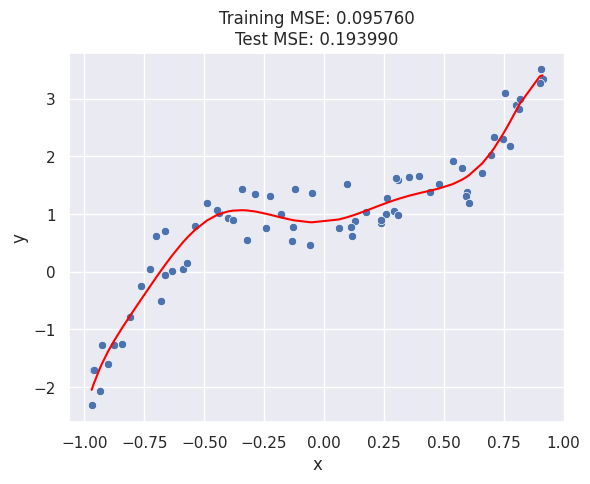

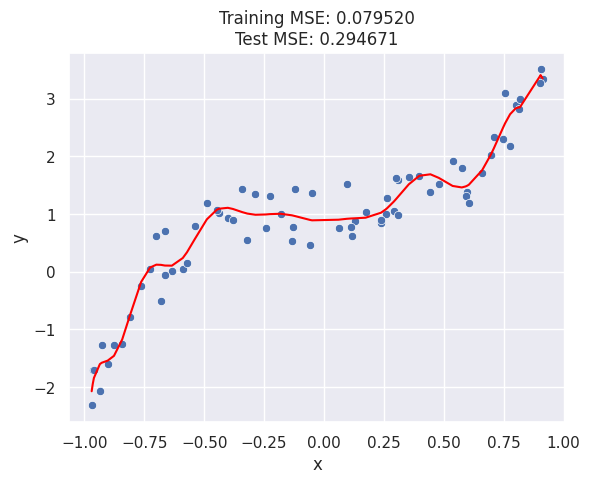

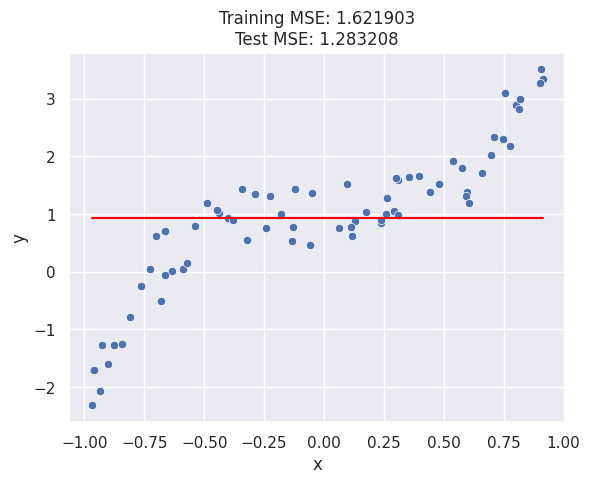

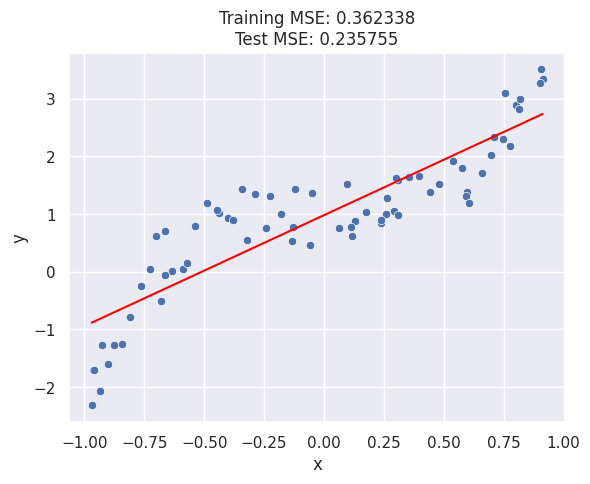

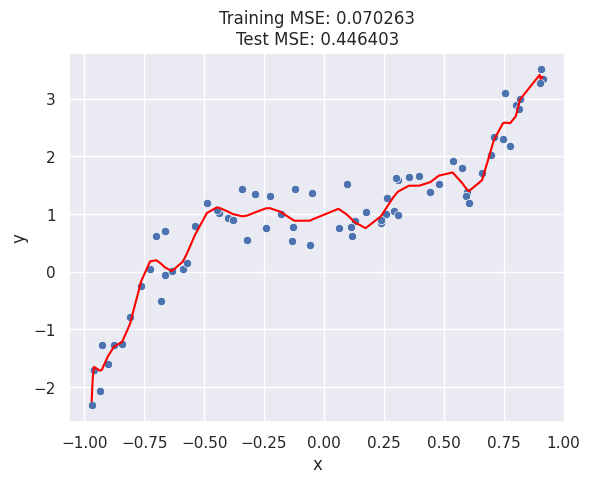

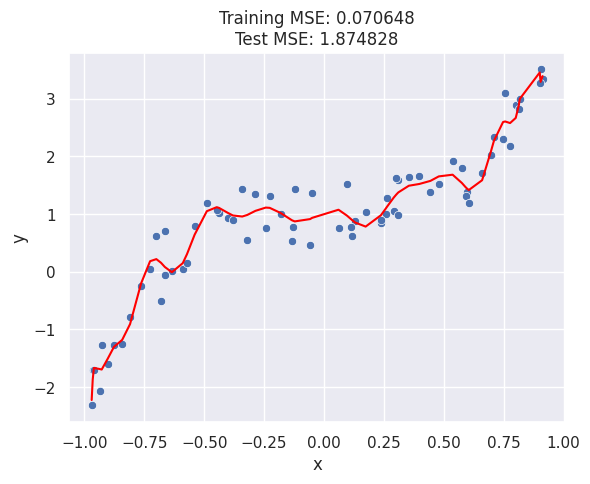

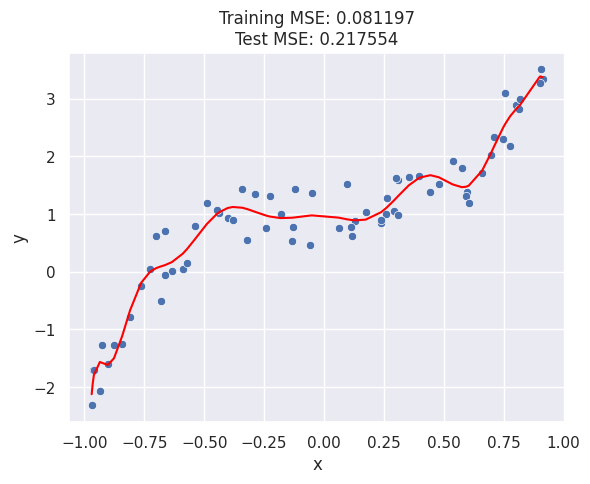

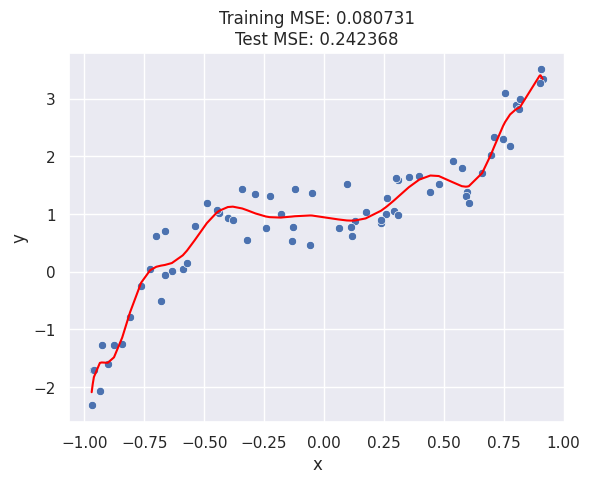

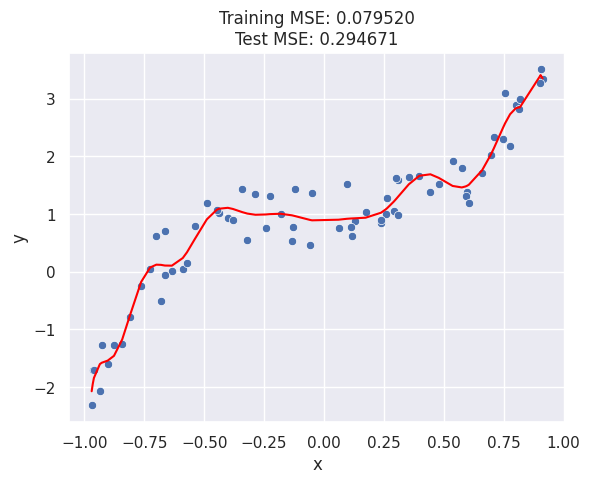

In [3]:
coefs=[1, 0.5, 0, 2.5]
n_samples = 100
sigma = 0.4

# generate polynimal data
x, y = generate_polynomial_regression_data(n=n_samples, coefs=coefs, sigma=sigma)

# divide into training and test set
# (we will later divide training data again, into training and validation set)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)


@interact(d = widgets.IntSlider(min=1, max=25, value=1), show_train = True, show_test = False)
def plot_poly_fit(d, show_train, show_test,
                  xtr = fixed(x_train), ytr = fixed(y_train),
                  xts = fixed(x_test), yts = fixed(y_test)):

  xtr_trans = np.power(xtr, np.arange(0, d))

  if show_train:
    sns.scatterplot(x = xtr.squeeze(), y = ytr);
  if show_test:
    sns.scatterplot(x = xts.squeeze(), y = yts);
  reg = LinearRegression().fit(xtr_trans, ytr)
  ytr_hat = reg.predict(xtr_trans)

  mse_tr = metrics.mean_squared_error(ytr, ytr_hat)
  mse_ts = metrics.mean_squared_error(yts, reg.predict(np.power(xts, np.arange(0, d))))

  sns.lineplot(x = xtr.squeeze(), y = ytr_hat, color='red')
  plt.xlabel('x');
  plt.ylabel('y');
  plt.title("Training MSE: %f\nTest MSE: %f" % (mse_tr, mse_ts))

### Cross validation

Splitting a data set for K-fold cross validation is conceptually very simple. The basic idea is:

-   We get a list of indices of training data, and decide how many “folds” we will use. The number of validation samples in each fold $N_{val}$ wil be the total number of training samples, divided by the number of folds.
-   Then, we iterate over the number of folds. In the first fold, we put the first $N_{val}$ samples in the validation set and exclude them from the training set. In the second fold, we put the second batch of $N_{val}$ samples in the validation set, and exclude them from the training set. Continue until $K$ folds.

In most circumstances, we will shuffle the list of training data indices first.

The `scikit-learn` library provides a `KFold` that does this for us:

In [4]:
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)

for isplit, idx in enumerate(kf.split(x_train)):
    idx_tr, idx_val = idx

although it’s also easy to do this ourselves:

In [5]:
nfold = 5                                   # number of folds (you choose!)
nval = x_train.shape[0]//nfold              # number of validation samples per fold
idx_split = [i*nval for i in range(nfold)]
idx_list = np.arange(x_train.shape[0])      # list of training data indices
np.random.shuffle(idx_list)                 # shuffle list of indices

for i, idx in enumerate(idx_split):
  idx_val = idx_list[idx:idx+nval]
  idx_tr = np.delete(idx_list, idx_val)

The outer loop can be used to divide the data into training and validation, but then we’ll also need an inner loop to train and validate each model for this particular fold.

In this case, suppose we want to evaluate polynomial models with different model orders from

$$d=1, \quad \hat{y} = w_0 + w_1 x$$

to

$$d=10, \quad \hat{y} = w_0 + w_1 x + w_2 x^2 + \ldots + w_{10} x^{10}$$

We could do something like this:

In [6]:
# create a k-fold object
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)

# model orders to be tested
dmax = 10
dtest_list = np.arange(1,dmax+1)
nd = len(dtest_list)

for isplit, idx in enumerate(kf.split(x_train)):
  idx_tr, idx_val = idx

  for dtest in dtest_list:
    # get "transformed" training and validation data
    x_train_dtest =  x_train[idx_tr]**np.arange(1,dtest+1)
    y_train_kfold =  y_train[idx_tr]
    x_val_dtest   =  x_train[idx_val]**np.arange(1,dtest+1)
    y_val_kfold   =  y_train[idx_val]

    # fit model on training data
    reg_dtest = LinearRegression().fit(x_train_dtest, y_train_kfold)

    # measure MSE on validation data
    y_hat   = reg_dtest.predict(x_val_dtest)
    mse_val = metrics.mean_squared_error(y_val_kfold, y_hat)
    r2_val  = metrics.r2_score(y_val_kfold, y_hat)

Notice, however, that there was a lot of wasted computation there. We computed the same polynomial features multiple times in different folds. Instead, we should compute the entire set of transformed features in advance, then just select the ones we need in each iteration over model order.

In [7]:
# create a k-fold object
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)

# model orders to be tested
dmax = 10
dtest_list = np.arange(1,dmax+1)
nd = len(dtest_list)

# create transformed features up to d_max
x_train_trans = x_train**np.arange(1,dmax+1)

for isplit, idx in enumerate(kf.split(x_train)):
  idx_tr, idx_val = idx

  for dtest in dtest_list:
    # get "transformed" training and validation data for this model order
    x_train_dtest =  x_train_trans[idx_tr,  :dtest]
    y_train_kfold = y_train[idx_tr]
    x_val_dtest   =  x_train_trans[idx_val, :dtest]
    y_val_kfold   = y_train[idx_val]

    # fit model on training data
    reg_dtest = LinearRegression().fit(x_train_dtest, y_train_kfold)

    # measure MSE on validation data
    y_hat   = reg_dtest.predict(x_val_dtest)
    mse_val = metrics.mean_squared_error(y_val_kfold, y_hat)
    r2_val  = metrics.r2_score(y_val_kfold, y_hat)

That’s much better! Let’s look at what this is doing - we’ll run it again with some extra visualization:

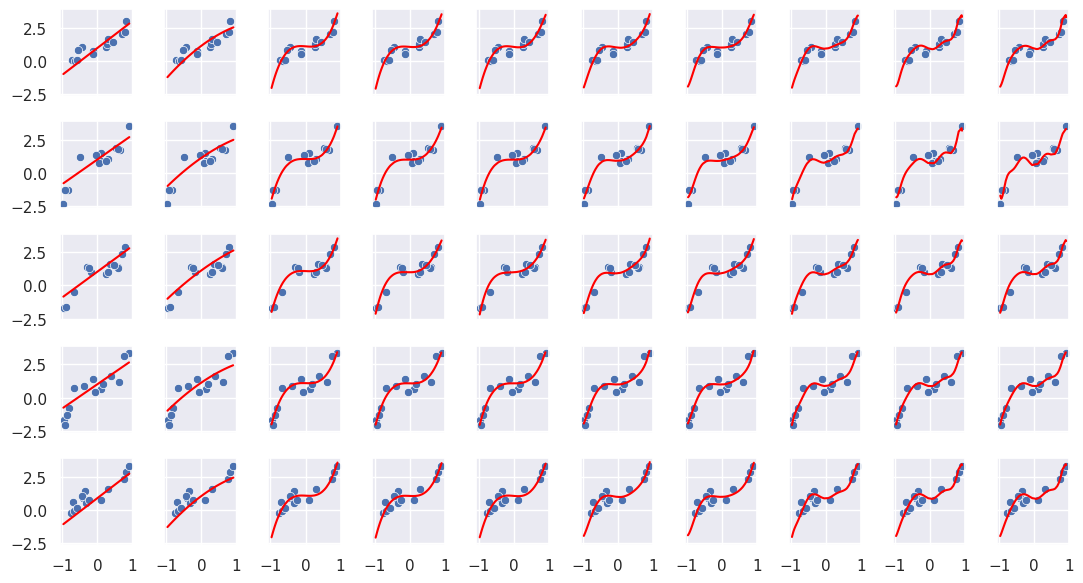

In [8]:
# create a k-fold object
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)

# model orders to be tested
dmax = 10
dtest_list = np.arange(1,dmax+1)
nd = len(dtest_list)

# create transformed features up to d_max
x_train_trans = x_train**np.arange(1,dmax+1)

# create a big figure
fig, axs = plt.subplots(nfold, nd, sharex=True, sharey=True)
fig.set_figheight(nfold+1);
fig.set_figwidth(nd+1);

for isplit, idx in enumerate(kf.split(x_train)):
  idx_tr, idx_val = idx

  for didx, dtest in enumerate(dtest_list):
    # get "transformed" training and validation data for this model order
    x_train_dtest =  x_train_trans[idx_tr,  :dtest]
    y_train_kfold = y_train[idx_tr]
    x_val_dtest   =  x_train_trans[idx_val, :dtest]
    y_val_kfold   = y_train[idx_val]

    # fit model on training data
    reg_dtest = LinearRegression().fit(x_train_dtest, y_train_kfold)

    # measure MSE on validation data
    y_hat   = reg_dtest.predict(x_val_dtest)
    mse_val = metrics.mean_squared_error(y_val_kfold, y_hat)
    r2_val  = metrics.r2_score(y_val_kfold, y_hat)

    # this is just for visualization/understanding - in a "real" problem you would not include this
    p = sns.lineplot(x = x_train_dtest[:,0].squeeze(), y = reg_dtest.predict(x_train_dtest), color='red', ax=axs[isplit, didx]);
    p = sns.scatterplot(x = x_val_dtest[:, 0].squeeze(), y = y_val_kfold,  ax=axs[isplit, didx]);

plt.tight_layout()


Finally, we’ll add some arrays in which to save the validation performance from each fold, so that we can average them afterward.

In [9]:
# create a k-fold object
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)

# model orders to be tested
dmax = 10
dtest_list = np.arange(1,dmax+1)
nd = len(dtest_list)

mse_val = np.zeros((nd,nfold))
r2_val  = np.zeros((nd,nfold))

# create transformed features up to d_max
x_train_trans = x_train**np.arange(1,dmax+1)

# loop over the folds
# the first loop variable tells us how many out of nfold folds we have gone through
# the second loop variable tells us how to split the data
for isplit, idx in enumerate(kf.split(x_train)):

  # these are the indices for the training and validation indices
  # for this iteration of the k folds
  idx_tr, idx_val = idx

  x_train_kfold = x_train_trans[idx_tr]
  y_train_kfold = y_train[idx_tr]
  x_val_kfold = x_train_trans[idx_val]
  y_val_kfold = y_train[idx_val]

  for didx, dtest in enumerate(dtest_list):

    # get transformed features
    x_train_dtest =  x_train_kfold[:, :dtest]
    x_val_dtest   =  x_val_kfold[:, :dtest]

    # fit data
    reg_dtest = LinearRegression().fit(x_train_dtest, y_train_kfold)

    # measure MSE on validation data
    y_hat = reg_dtest.predict(x_val_dtest)
    mse_val[didx, isplit] = metrics.mean_squared_error(y_val_kfold, y_hat)
    r2_val[didx, isplit] = metrics.r2_score(y_val_kfold, y_hat)

Here is the mean (across K folds) validation error for each model order:

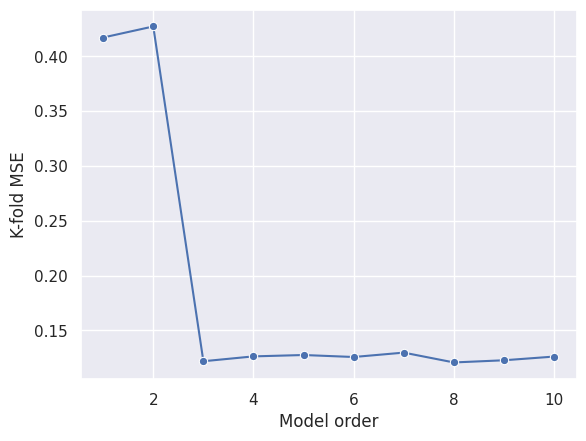

In [10]:
sns.lineplot(x=dtest_list, y=mse_val.mean(axis=1), marker='o');
plt.xlabel("Model order");
plt.ylabel("K-fold MSE");

Let’s see which model order gave us the lowest MSE on the validation data:

In [11]:
idx_min = np.argmin(mse_val.mean(axis=1))
d_min_mse = dtest_list[idx_min]
d_min_mse

8

In [12]:
mse_val.mean(axis=1)

array([0.41702612, 0.4271202 , 0.1218438 , 0.1262696 , 0.12752042,
       0.12570823, 0.12970347, 0.1207393 , 0.12272555, 0.1261022 ])

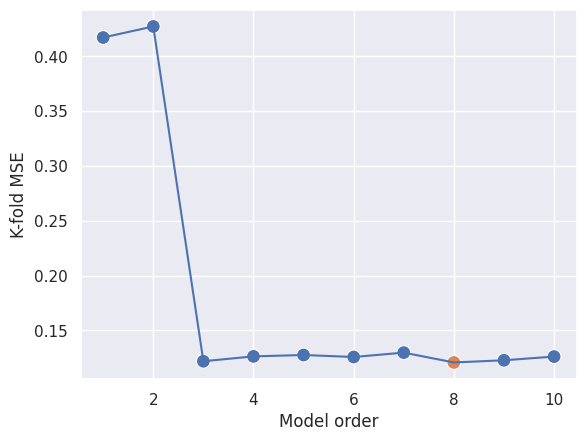

In [13]:
sns.lineplot(x=dtest_list, y=mse_val.mean(axis=1));
sns.scatterplot(x=dtest_list, y=mse_val.mean(axis=1), hue=dtest_list==d_min_mse, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold MSE");

We can also select by highest R2 (instead of lowest MSE):

In [14]:
idx_max = np.argmax(r2_val.mean(axis=1))
d_max_r2 = dtest_list[idx_max]
d_max_r2

8

In [15]:
r2_val.mean(axis=1)

array([0.42494429, 0.45419615, 0.8480156 , 0.84705874, 0.84615103,
       0.85355542, 0.85230817, 0.86694183, 0.85896852, 0.85691485])

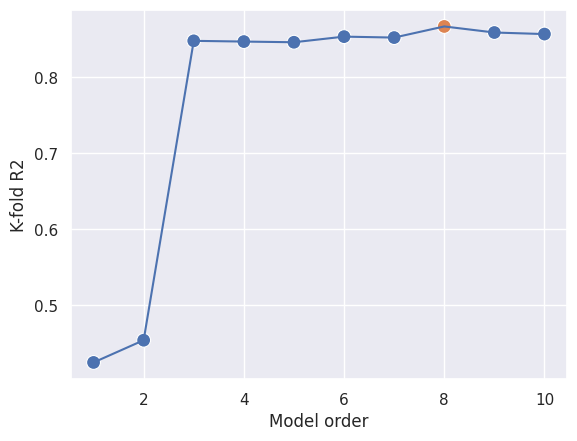

In [16]:
sns.lineplot(x=dtest_list, y=r2_val.mean(axis=1));
sns.scatterplot(x=dtest_list, y=r2_val.mean(axis=1), hue=dtest_list==d_max_r2, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold R2");

### Model selection using 1-SE “rule”

When using the minimum K-fold CV error for model selection, we sometimes will still select an overly complex model <sup>\[2\]</sup>.

As an alternative, we can use the “one standard error rule” <sup>\[3\]</sup>. According to this “rule”, we choose the least complex model whose error is no more than one standard error above the error of the best model - i.e. the simplest model whose performance is comparable to the best model.

<small>\[2\] See [Cawley & Talbot (J of Machine Learning Research, 2010)](http://www.jmlr.org/papers/volume11/cawley10a/cawley10a.pdf) for more on this.</small>

<small>\[3\] See Chapter 7 of [Elements of Statistical Learning](https://web.stanford.edu/~hastie/Papers/ESLII.pdf) </small>

We apply this rule as follows:

-   Find the MSE for each fold for each model candidate
-   For each model candidate, compute the mean and standard error of the MSE over the $K$ folds. We will compute the standard error as $$\frac{\sigma_{\text{MSE}}}{\sqrt{K-1}}$$ where $\sigma_{\text{MSE}}$ is the standard deviation of the MSE over the $K$ folds.
-   Find the model with the smallest mean MSE (across the $K$ folds). Compute the *target* as mean MSE + SE for this model.
-   Select the least complex model whose mean MSE is below the target.

This works for any metric that is a “lower is better” metric. If you are using a “higher is better” metric, such as R2, for example, you would modify the last two steps:

-   Find the model with the **largest** mean R2 (across the $K$ folds). Compute the **mean R2 - SE of R2** for this model. Call this quantity the *target*.
-   Select the least complex model whose mean R2 is **above** the target.

In [18]:
idx_min = np.argmin(mse_val.mean(axis=1))
target = mse_val[idx_min,:].mean() + mse_val[idx_min,:].std()/np.sqrt(nfold-1)
# np.where returns indices of values where condition is satisfied
idx_one_se = np.where(mse_val.mean(axis=1) <= target)
d_one_se = np.min(dtest_list[idx_one_se])
d_one_se

3

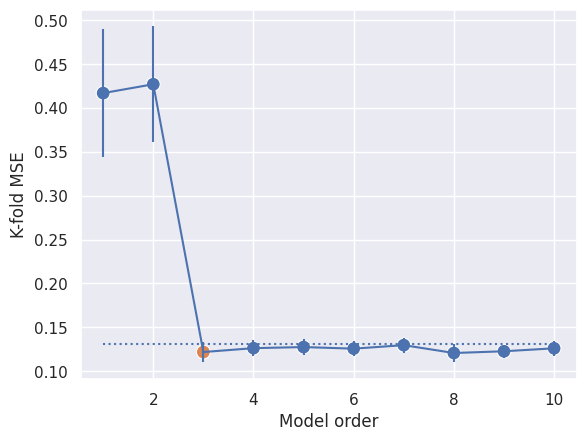

In [19]:
plt.errorbar(x=dtest_list, y=mse_val.mean(axis=1), yerr=mse_val.std(axis=1)/np.sqrt(nfold-1));
plt.hlines(y=target, xmin=np.min(dtest_list), xmax=np.max(dtest_list), ls='dotted')
sns.scatterplot(x=dtest_list, y=mse_val.mean(axis=1), hue=dtest_list==d_one_se, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold MSE");

In [20]:
idx_max = np.argmax(r2_val.mean(axis=1))
target_r2 = r2_val[idx_max,:].mean() - r2_val[idx_max,:].std()/np.sqrt(nfold-1)
# np.where returns indices of values where condition is satisfied
idx_one_se_r2 = np.where(r2_val.mean(axis=1) >= target_r2)
d_one_se_r2 = np.min(dtest_list[idx_one_se_r2])
d_one_se_r2

3

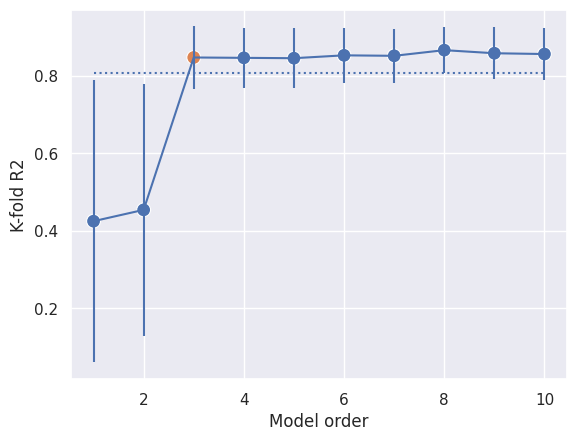

In [21]:
plt.errorbar(x=dtest_list, y=r2_val.mean(axis=1), yerr=r2_val.std(axis=1)/np.sqrt(nfold-1));
plt.hlines(y=target_r2, xmin=np.min(dtest_list), xmax=np.max(dtest_list), ls='dotted')
sns.scatterplot(x=dtest_list, y=r2_val.mean(axis=1), hue=dtest_list==d_one_se_r2, s=100, legend=False);

plt.xlabel("Model order");
plt.ylabel("K-fold R2");

Predicting the course of COVID with a “cubic model”
---------------------------------------------------

As part of the materials for this lesson, you read about some attempts early in the COVID-19 pandemic to predict how the number of cases or deaths would evolve. You were asked to consider:

> The forecasts produced by these models were all very wrong, but they appeared to fit the data well! What was wrong with the approach used to produce these models? How did they miscalculate so badly?

Now, we’ll take that process apart, see what went wrong, and see what we could have done differently.

First, we will get U.S. COVID data and read it in to our notebook environment. We’ll also add a field called `daysElapsed` which will count the number of days since March 1, 2020 for each row of data.

In [22]:
!wget https://covidtracking.com/data/download/national-history.csv -O national-history.csv

--2023-10-01 22:42:14--  https://covidtracking.com/data/download/national-history.csv
Resolving covidtracking.com (covidtracking.com)... 104.21.60.252, 172.67.203.145, 2606:4700:3035::6815:3cfc, ...
Connecting to covidtracking.com (covidtracking.com)|104.21.60.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘national-history.csv’

national-history.cs     [ <=>                ]  41.95K  --.-KB/s    in 0.007s  

2023-10-01 22:42:14 (5.91 MB/s) - ‘national-history.csv’ saved [42952]



In [23]:
df = pd.read_csv('national-history.csv')
df.date = pd.to_datetime(df.date)
df = df.sort_values(by="date")
df = df.assign(daysElapsed =  (df.date - pd.to_datetime('2020-03-01')).dt.days)
df.head()

,date,death,deathIncrease,inIcuCumulative,inIcuCurrently,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,negative,negativeIncrease,onVentilatorCumulative,onVentilatorCurrently,positive,positiveIncrease,states,totalTestResults,totalTestResultsIncrease,daysElapsed
419,2020-01-13,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,NaN,0,1,0,0,-48
418,2020-01-14,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0,-47
417,2020-01-15,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0,-46
416,2020-01-16,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0,-45
415,2020-01-17,NaN,0,NaN,NaN,0,NaN,NaN,NaN,0,NaN,NaN,0.0,0,1,0,0,-44


:::

Let’s assume that we are making this prediction sometime near the beginning of May 2020 (like in the reading), well into the first wave in the U.S., and we want to predict when this wave will fall off (deaths go back to zero).

We’ll use all of the data up to May 2020 for training. But afterwards, we’ll go back and see how well our model did by comparing its predictions for May and June 2020 to the real course of the pandemic.

In [24]:
df_tr = df[(df.date <= '2020-05-01') & (df.date > '2020-03-01')]
df_ts = df[(df.date < '2020-06-30') & (df.date >= '2020-05-01')]

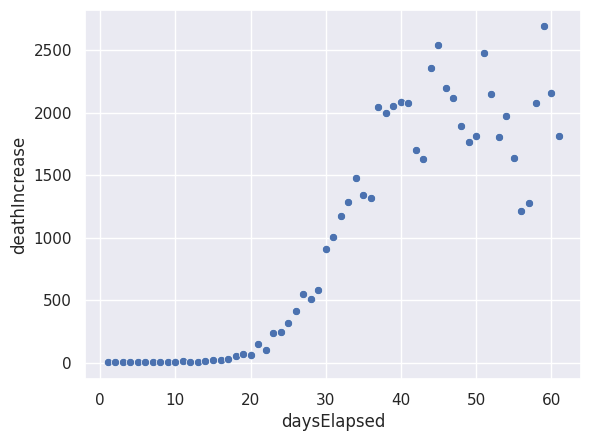

In [25]:
sns.scatterplot(x=df_tr.daysElapsed, y=df_tr.deathIncrease);

Furthermore, we will use a polynomial basis to fit a linear regression model, so let’s generate “transformed” versions of our feature: days since the beginning of March 2020.

In [26]:
df_tr_poly = df_tr.daysElapsed.values.reshape(-1,1)**np.arange(1, 5)
df_ts_poly = df_ts.daysElapsed.values.reshape(-1,1)**np.arange(1, 5)

Let’s now go ahead and fit a model to our training data, then compute the R2 score for the model. It seems like a good fit on the training data:

In [27]:
reg_covid = LinearRegression().fit(df_tr_poly, df_tr.deathIncrease)
deathIncrease_fitted = reg_covid.predict(df_tr_poly)
metrics.r2_score(df_tr.deathIncrease, deathIncrease_fitted)

0.9044899717082454

and looks reasonably good in this visualization (although of course, we recognize that negative deaths should be impossible):

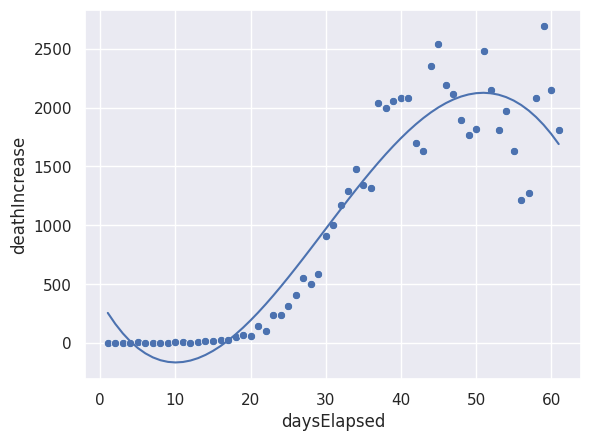

In [28]:
sns.scatterplot(x=df_tr.daysElapsed, y=df_tr.deathIncrease);
sns.lineplot(x=df_tr.daysElapsed, y=deathIncrease_fitted);

But despite looking good on training data, the model does a terrible job of predicting the end of the first wave. The model predicts that deaths fall to zero around day 70, but we can see that the actual fall off is much slower, and there are still hundreds of deaths each day at day 120.

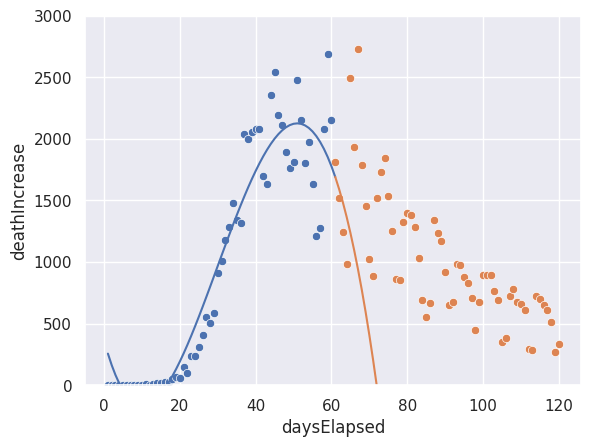

In [29]:
deathIncrease_fitted_future = reg_covid.predict(df_ts_poly)

sns.scatterplot(x=df_tr.daysElapsed, y=df_tr.deathIncrease);
sns.lineplot(x=df_tr.daysElapsed, y=deathIncrease_fitted);

sns.scatterplot(x=df_ts.daysElapsed, y=df_ts.deathIncrease);
sns.lineplot(x=df_ts.daysElapsed, y=deathIncrease_fitted_future);

plt.ylim(0, 3000);

A better way to train and evaluate this model would be to use a validation set that is *not* used to fit the model parameters to evaluate its performance, or even better: to use cross validation to evaluate different candidate models.

Let’s see how we might do that for this time series data. One possible approach would be to create multiple “folds”, where in each fold, the number of samples in the training set increases (and the validation set is always the ten days after the training set - we are validating whether our model can predict deaths ten days into the future).

Here’s what that might look like (blue dots are training data, orange dots are validation data):

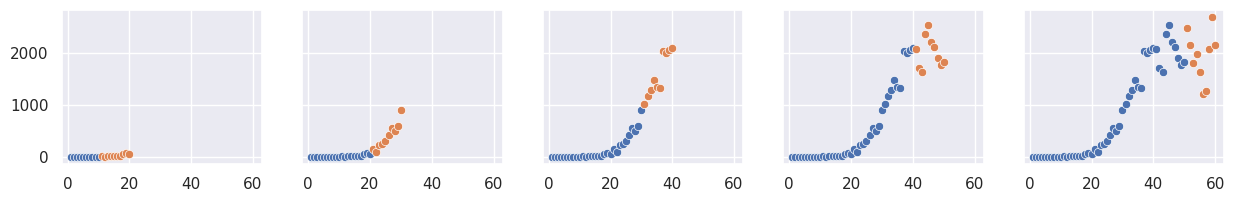

In [30]:
idxval = [10, 20, 30, 40, 50]
nfold = len(idxval)

fig, axs = plt.subplots(1, nfold, sharex=True, sharey=True)
fig.set_figwidth(15);
fig.set_figheight(2);

for isplit, idx in enumerate(idxval):

    x_train_kfold = df_tr_poly[:idx]
    y_train_kfold = df_tr.deathIncrease.values[:idx]
    x_val_kfold = df_tr_poly[idx:idx+10]
    y_val_kfold = df_tr.deathIncrease.values[idx:idx+10]

    p = sns.scatterplot(x=x_train_kfold[:,0], y=y_train_kfold, ax=axs[isplit]);
    p = sns.scatterplot(x=x_val_kfold[:,0], y=y_val_kfold, ax=axs[isplit]);

Now we can use this cross validation to evaluate different polynomial model orders. For each model order, and each “fold”, we’ll compute the training and validation MSE and R2.

In [31]:
# model orders to be tested
dmax = 4
dtest_list = np.arange(1,dmax+1)
nd = len(dtest_list)

idxval = [10, 20, 30, 40, 50]
nfold = len(idxval)

mse_val = np.zeros((nd,nfold))
r2_val  = np.zeros((nd,nfold))
mse_tr  = np.zeros((nd,nfold))
r2_tr   = np.zeros((nd,nfold))

# loop over the folds
# the first loop variable tells us how many out of nfold folds we have gone through
# the second loop variable tells us how to split the data
for isplit, idx in enumerate(idxval):

    x_train_kfold = df_tr_poly[:idx]
    y_train_kfold = df_tr.deathIncrease.values[:idx]
    x_val_kfold = df_tr_poly[idx:idx+10]
    y_val_kfold = df_tr.deathIncrease.values[idx:idx+10]

    for didx, dtest in enumerate(dtest_list):

      # get transformed features
      x_train_dtest =  x_train_kfold[:, :dtest]
      x_val_dtest   =  x_val_kfold[:, :dtest]

      # fit data
      reg_dtest = LinearRegression().fit(x_train_dtest, y_train_kfold)

      # measure MSE on validation data
      y_hat = reg_dtest.predict(x_val_dtest)
      mse_val[didx, isplit] = metrics.mean_squared_error(y_val_kfold, y_hat)
      r2_val[didx, isplit] = metrics.r2_score(y_val_kfold, y_hat)

      # measure MSE on training data
      y_hat_tr = reg_dtest.predict(x_train_dtest)
      mse_tr[didx, isplit] = metrics.mean_squared_error(y_train_kfold, y_hat_tr)
      r2_tr[didx, isplit] = metrics.r2_score(y_train_kfold, y_hat_tr)

Looking at the result, we see that the training R2 is reasonably good for the polynomial model (here, we show the mean across folds for each polynomial degree):

In [32]:
r2_tr.mean(axis=1)

array([0.58906923, 0.75718313, 0.80192395, 0.83837349])

But the validation R2 tells a more accurate story: the model is wildly overfitting, and it has no predictive power whatsoever.

In [33]:
r2_val.mean(axis=1)

array([ -2.39418417,  -5.92043776,  -7.70686658, -38.93609687])